In [1]:
# pip install numpy pandas opencv-python tensorflow matplotlib pillow albumentations scikit-learn pickle5 seaborn

In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A

from sklearn.metrics import f1_score, classification_report
import pickle
from sklearn.model_selection import StratifiedKFold
from numpy import array
from random import shuffle, seed

2024-12-27 14:45:11.562029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-27 14:45:11.665764: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/nimmy/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates(

In [3]:
list_paths = []
for subdir, dirs, files in os.walk("train/train"):
    for file in files:
        filepath = subdir + os.sep + file
        list_paths.append(filepath)
        
list_train = [filepath for filepath in list_paths if "train/" in filepath]
seed(420)
shuffle(list_train)
list_test = [filepath for filepath in list_paths if "test/" in filepath]

In [4]:
list_train[:5]

['train/train/train/Motorola-Nexus-6/(MotoNex6)56.jpg',
 'train/train/train/HTC-1-M7/(HTC-1-M7)74.jpg',
 'train/train/train/Motorola-Droid-Maxx/(MotoMax)23.jpg',
 'train/train/train/Sony-NEX-7/(Nex7)4.JPG',
 'train/train/train/iPhone-4s/(iP4s)131.jpg']

In [5]:
def get_class_from_path(filepath):
    return os.path.dirname(filepath).split(os.sep)[-1]

In [6]:
labels = [get_class_from_path(filepath) for filepath in list_train]

In [7]:
labels[:5]

['Motorola-Nexus-6',
 'HTC-1-M7',
 'Motorola-Droid-Maxx',
 'Sony-NEX-7',
 'iPhone-4s']

In [8]:
train_data = pd.DataFrame(labels, columns=['class'])
train_data['path'] = list_train
train_data.head()

,class,path
0,Motorola-Nexus-6,train/train/train/Motorola-Nexus-6/(MotoNex6)5...
1,HTC-1-M7,train/train/train/HTC-1-M7/(HTC-1-M7)74.jpg
2,Motorola-Droid-Maxx,train/train/train/Motorola-Droid-Maxx/(MotoMax...
3,Sony-NEX-7,train/train/train/Sony-NEX-7/(Nex7)4.JPG
4,iPhone-4s,train/train/train/iPhone-4s/(iP4s)131.jpg


<Axes: xlabel='class'>

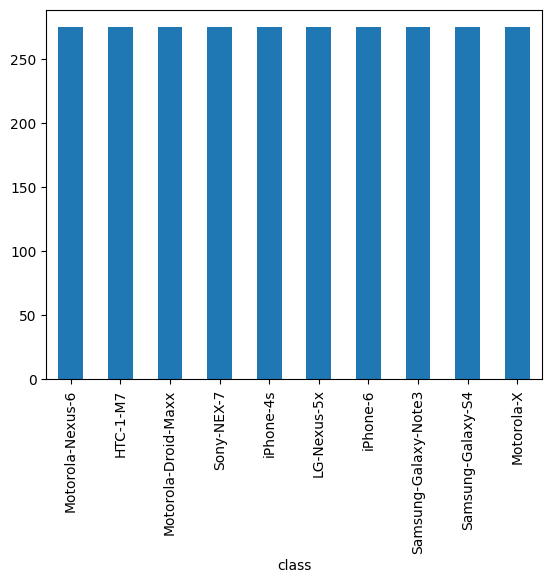

In [9]:
train_data['class'].value_counts().sort_values().plot(kind='bar')

In [10]:
X = train_data['path']
y = train_data['class']

In [11]:
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
splits = list(splitter.split(X=X, y=y))

In [12]:
y.shape

(2750,)

In [13]:
y = pd.get_dummies(y)
y.head()

dict_map = {"0": "HTC-1-M7", 
            "1": "LG-Nexus-5x", 
            "2": "Motorola-Droid-Maxx", 
            "3": "Motorola-Nexus-6", 
            "4": "Motorola-X", 
            "5": "Samsung-Galaxy-Note3",
            "6": "Samsung-Galaxy-S4",
            "7": "Sony-NEX-7",
            "8": "iPhone-4s",
            "9": "iPhone-6"}

In [14]:
def open_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [15]:
SHAPE = 512

train_augmentations = A.Compose([
    A.RandomCrop(height=SHAPE, width=SHAPE),
    A.RandomGamma(gamma_limit=(80, 120), p=0.8),
    A.ImageCompression(quality_lower=70, quality_upper=90, p=0.9),
    A.GridDistortion(interpolation=cv2.INTER_CUBIC, p=0.9)
])

teste_augmentations = A.Compose([
    A.CenterCrop(height=SHAPE, width=SHAPE)
])


In [16]:
class CameraDataset(tf.keras.utils.Sequence):
    def __init__(self, X_set, y_set, batch_size, augmenter=None, test=False, *args, **kwargs):
        
        self.batch_size = batch_size
        self.x_set = X_set
        self.y_set = y_set
        self.test = test
        self.augmenter = augmenter
        
    def __len__(self):
        return int(len(self.x_set) / self.batch_size)
    
    
    def __getitem__(self, index):
        X = self.x_set[index * self.batch_size : (index + 1) * self.batch_size]        
        y = self.y_set[index * self.batch_size : (index + 1) * self.batch_size]
        
        X = [(self.augmenter(image=open_image(x))['image']) for x in X]
        
        if self.test:
            return np.array(X)
        
        return np.array(X), y.values

In [17]:
train_dataset = CameraDataset(X, y, batch_size=8, augmenter=train_augmentations)

In [18]:
x_set, y_set = train_dataset.__getitem__(50)

In [19]:
x_set[0].shape

(512, 512, 3)

In [20]:
y_set[0]

array([False, False, False, False, False, False, False, False,  True,
       False])

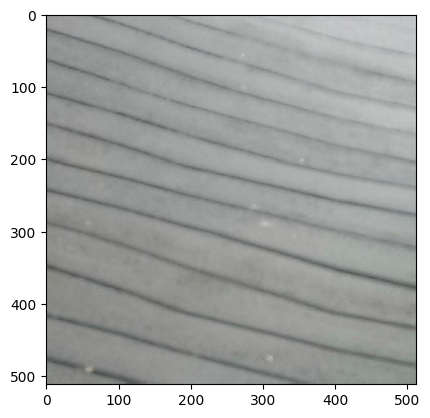

In [21]:
plt.imshow(x_set[3])

In [22]:
def build_model():
    base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[SHAPE, SHAPE, 3])
    base_model.trainable = True
    inputs =tf.keras.layers.Input(shape=(SHAPE,SHAPE,3))
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    x = base_model(x, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model =tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary() 
    return model

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

train_dataset = CameraDataset(X_train, y_train, batch_size=10,augmenter=train_augmentations)
val_dataset = CameraDataset(X_test, y_test, batch_size=10,augmenter=teste_augmentations)

In [24]:
model = build_model()

2024-12-27 14:45:20.722962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 512, 512, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 16, 16, 1920)      18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0     

In [25]:
# file_path = "weights.best.hdf5"
# model = tf.keras.models.load_model(file_path)

In [26]:
file_path = "weights.best.keras"

checkpoint = tf.keras.callbacks.ModelCheckpoint(file_path, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]

history = model.fit(train_dataset, validation_data=val_dataset, epochs=100, batch_size=10, callbacks=callbacks_list)

Epoch 1/100
220/220 [==============================] - 620s 3s/step - loss: 2.1650 - accuracy: 0.2068 - val_loss: 1.8402 - val_accuracy: 0.4509 - lr: 1.0000e-04
Epoch 2/100
220/220 [==============================] - 571s 3s/step - loss: 1.9345 - accuracy: 0.3418 - val_loss: 1.4015 - val_accuracy: 0.6018 - lr: 1.0000e-04
Epoch 3/100
220/220 [==============================] - 573s 3s/step - loss: 1.7180 - accuracy: 0.4227 - val_loss: 1.3054 - val_accuracy: 0.6164 - lr: 1.0000e-04
Epoch 4/100
220/220 [==============================] - 478s 2s/step - loss: 1.5440 - accuracy: 0.4905 - val_loss: 1.0692 - val_accuracy: 0.7073 - lr: 1.0000e-04
Epoch 5/100
220/220 [==============================] - 569s 3s/step - loss: 1.3893 - accuracy: 0.5414 - val_loss: 0.8701 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 6/100
220/220 [==============================] - 572s 3s/step - loss: 1.3243 - accuracy: 0.5827 - val_loss: 0.7327 - val_accuracy: 0.8073 - lr: 1.0000e-04
Epoch 7/100
220/220 [=============

In [37]:
file_path = "weights.best.keras"
model2 = tf.keras.models.load_model(file_path)
# X_test = np.array([read_and_array(filepath) for filepath in X_test])
# pred_mean = model2.predict(X_test)

In [28]:
# # Generate predictions for the validation dataset
# predictions = model.predict(val_dataset)

# # Convert predicted probabilities to class indices
# y_pred = np.argmax(predictions, axis=1)

# # Display the first few predictions
# print("Predicted class indices:", y_pred[:10])
# # Convert ground truth from one-hot encoding to class indices
# y_true = np.argmax(np.concatenate([y for x, y in val_dataset], axis=0), axis=1)

# # Display the first few true labels
# print("True class indices:", y_true[:10])


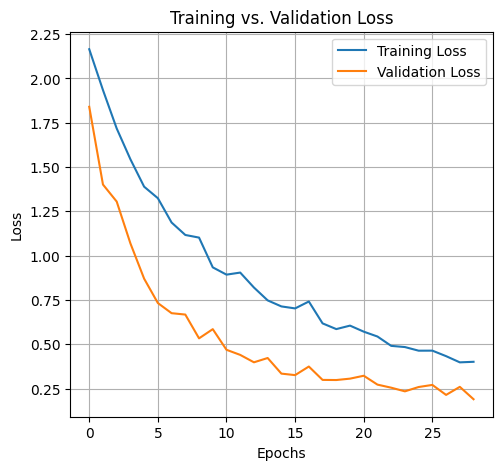

In [29]:
plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

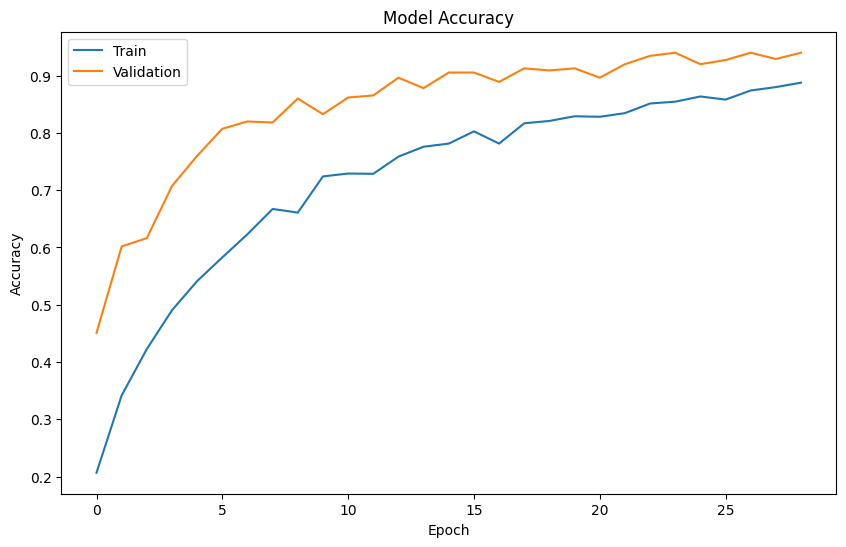

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


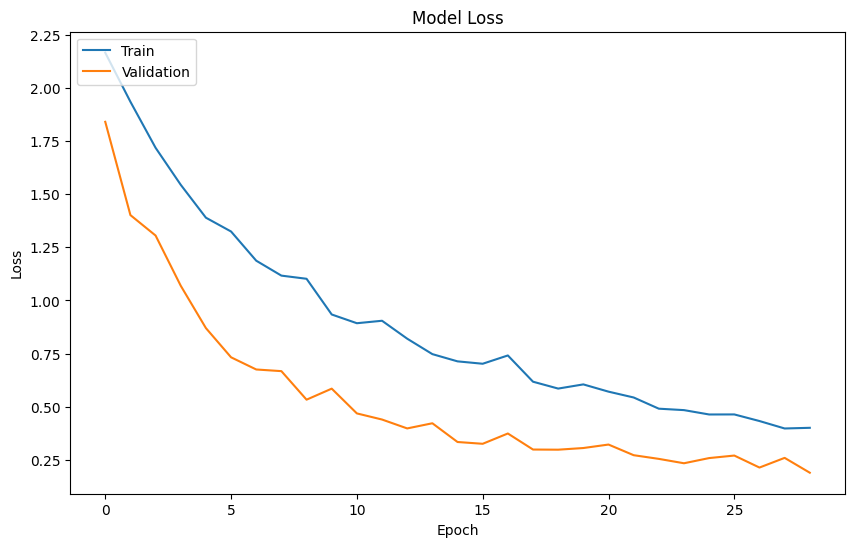

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


55/55 [==============================] - 56s 964ms/step


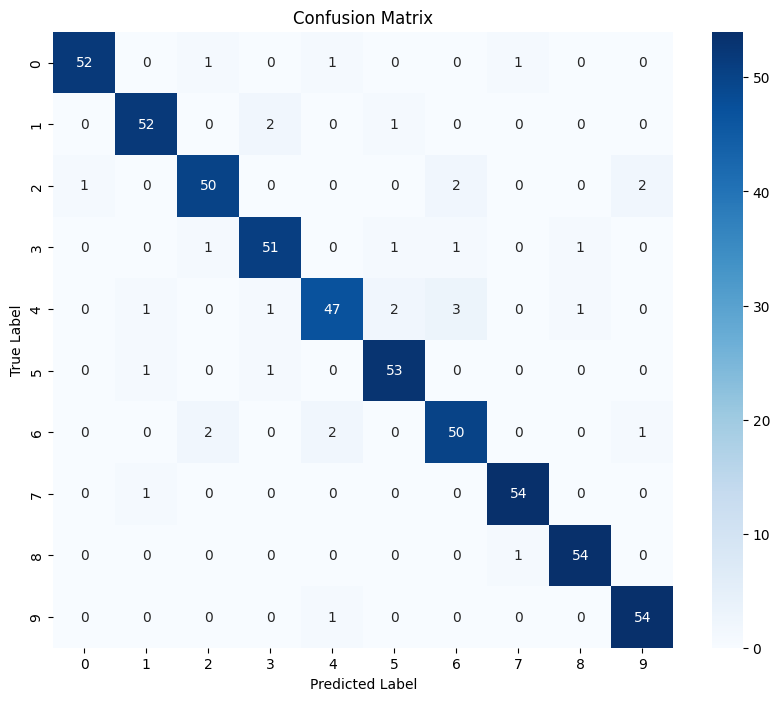

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test.values, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [47]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming val_dataset and train_dataset are your validation and training datasets
# and y_test and y_train are the actual labels for validation and training datasets respectively

# Predict on validation dataset
y_pred1 = model.predict(val_dataset)
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_true1 = np.argmax(y_test, axis=1)  # Assuming y_test is already a numpy array

# Predict on training dataset
y_pred2 = model.predict(train_dataset)
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(y_train, axis=1)  # Assuming y_train is already a numpy array

# Calculate and print validation accuracy
val_accuracy = accuracy_score(y_true1, y_pred_classes1)
print(f"Model validation accuracy: {val_accuracy}")

# Calculate and print training accuracy
train_accuracy = accuracy_score(y_true2, y_pred_classes2)
print(f"Model training accuracy: {train_accuracy}")


220/220 [==============================] - 591s 3s/step
Model validation accuracy: 0.94
Model training accuracy: 0.9322727272727273


In [48]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming val_dataset and train_dataset are your validation and training datasets
# and y_test and y_train are the actual labels for validation and training datasets respectively

# Predict on validation dataset
y_pred1 = model2.predict(val_dataset)
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_true1 = np.argmax(y_test, axis=1)  # Assuming y_test is already a numpy array

# Predict on training dataset
y_pred2 = model2.predict(train_dataset)
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(y_train, axis=1)  # Assuming y_train is already a numpy array

# Calculate and print validation accuracy
val_accuracy = accuracy_score(y_true1, y_pred_classes1)
print(f"Model validation accuracy: {val_accuracy}")

# Calculate and print training accuracy
train_accuracy = accuracy_score(y_true2, y_pred_classes2)
print(f"Model training accuracy: {train_accuracy}")


220/220 [==============================] - 572s 3s/step
Model validation accuracy: 0.94
Model training accuracy: 0.9227272727272727


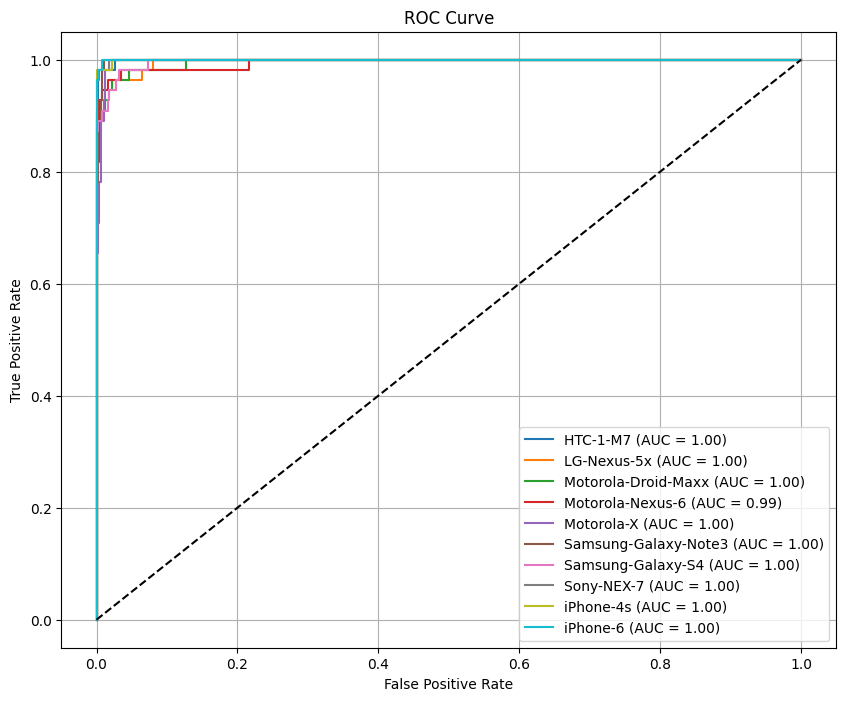

In [49]:
from sklearn.metrics import roc_curve, auc

classes = list(dict_map.values())
# print(classes)

# Ensure y_test and y_pred are NumPy arrays
if not isinstance(y_test, np.ndarray):
    y_test = y_test.values  # Convert DataFrame to NumPy array if necessary

if not isinstance(y_pred, np.ndarray):
    y_pred = y_pred.values  # Convert DataFrame to NumPy array if necessary

# Generate ROC Curve and AUC for each class
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])  # NumPy slicing works here
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid()
plt.show()
